<a href="https://colab.research.google.com/github/Vishnup211/Stock-Market-Portfolio-Optimization/blob/main/Stock_Market_Portfolio_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importing And Installing Libraries**

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import date, timedelta

In [10]:
end_date= date.today().strftime("%Y-%m-%d")
start_date= (date.today() - timedelta(days=365)).strftime("%Y-%m-%d")

## This is the list of Stock Ticker to Download

In [11]:
tickers=['RELIANCE.NS','TCS.NS','INFY.NS','HDFCBANK.NS']
data=yf.download(tickers,start=start_date,end=end_date,progress=False)

In [12]:
data=data.reset_index()

In [20]:
data_melted=data.melt(id_vars=['Date'],var_name=['Attribute','Ticker'])

In [22]:
data_pivoted=data_melted.pivot_table(index=['Date','Ticker'],columns='Attribute',values='value',aggfunc='first')

In [23]:
stock_data=data_pivoted.reset_index()

In [24]:
print(stock_data.head())

Attribute                      Date       Ticker    Adj Close        Close  \
0         2023-09-04 00:00:00+00:00  HDFCBANK.NS  1563.203857  1584.550049   
1         2023-09-04 00:00:00+00:00      INFY.NS  1438.272705  1465.099976   
2         2023-09-04 00:00:00+00:00  RELIANCE.NS  2402.545654  2410.699951   
3         2023-09-04 00:00:00+00:00       TCS.NS  3361.653320  3418.500000   
4         2023-09-05 00:00:00+00:00  HDFCBANK.NS  1553.683838  1574.900024   

Attribute         High          Low         Open      Volume  
0          1591.449951  1574.900024  1590.000000  12536819.0  
1          1470.000000  1434.699951  1443.000000   4609014.0  
2          2423.649902  2405.300049  2412.649902   4673813.0  
3          3432.850098  3370.050049  3378.000000   1828332.0  
4          1588.400024  1570.599976  1588.400024  19356041.0  


## Checking The Perfomance Of The Comapanies In Stock Market

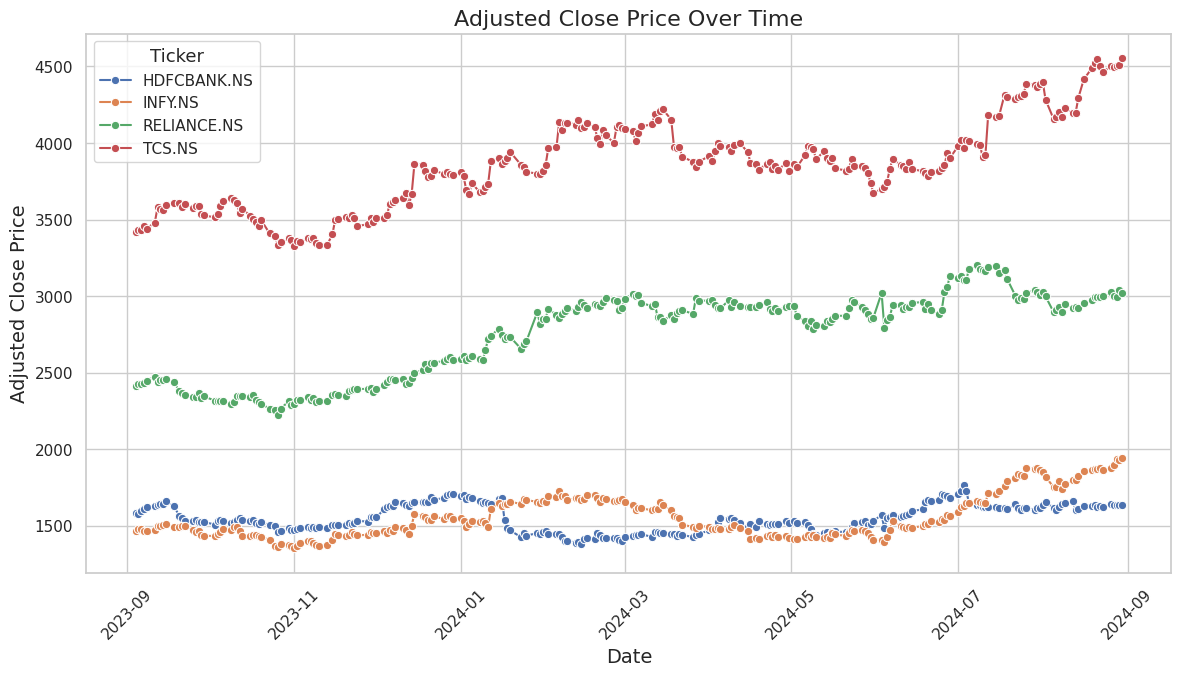

In [29]:
stock_data['Date']=pd.to_datetime(stock_data['Date'])
stock_data.set_index('Date',inplace=True)
stock_data.reset_index(inplace=True)
plt.figure(figsize=(14,7))
sns.set(style='whitegrid')
sns.lineplot(data=stock_data,x='Date',y='Close',hue='Ticker',marker='o')

plt.title('Adjusted Close Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Adjusted Close Price', fontsize=14)
plt.legend(title='Ticker', title_fontsize='13', fontsize='11')
plt.grid(True)

plt.xticks(rotation=45)

plt.show()

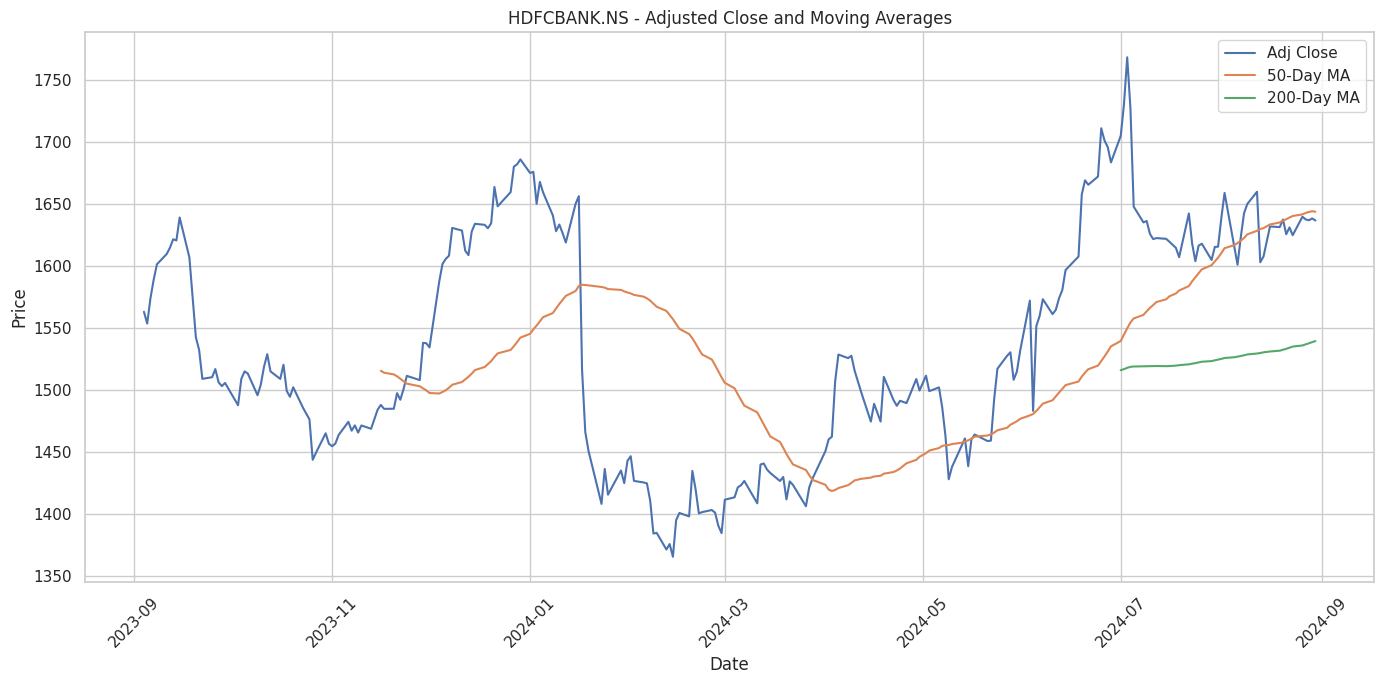

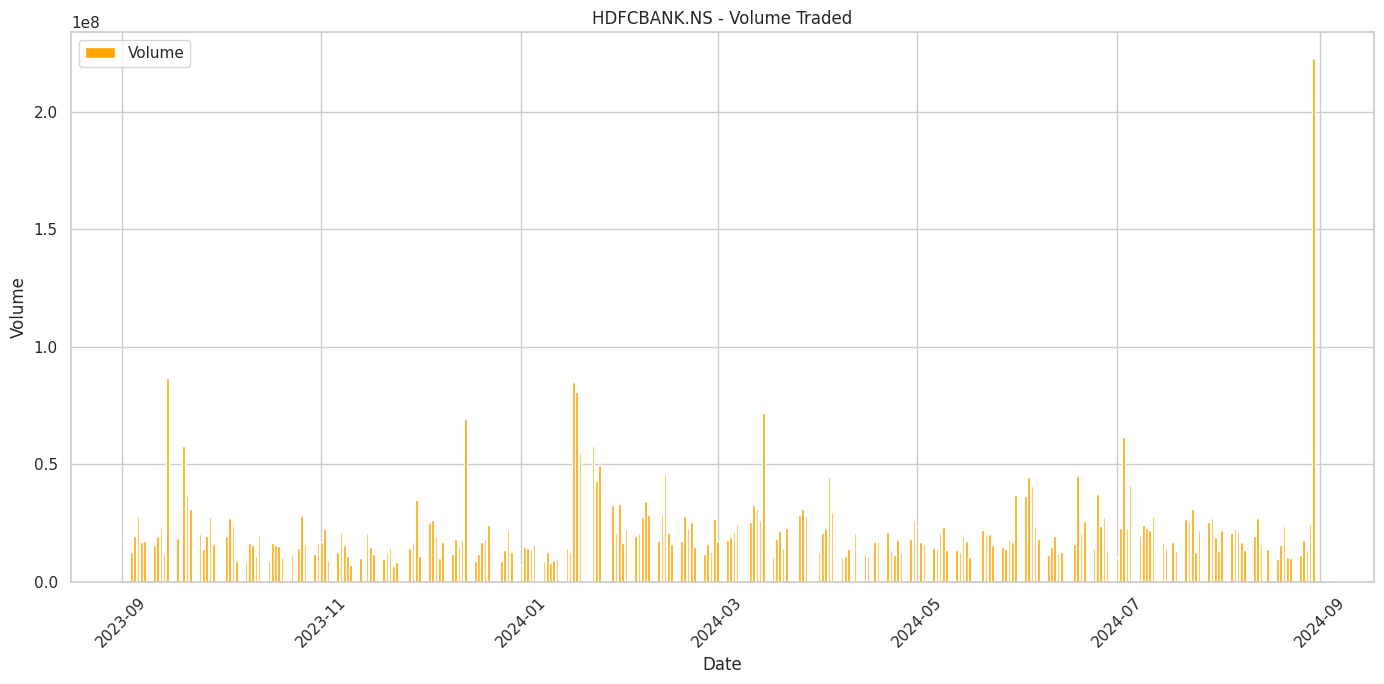

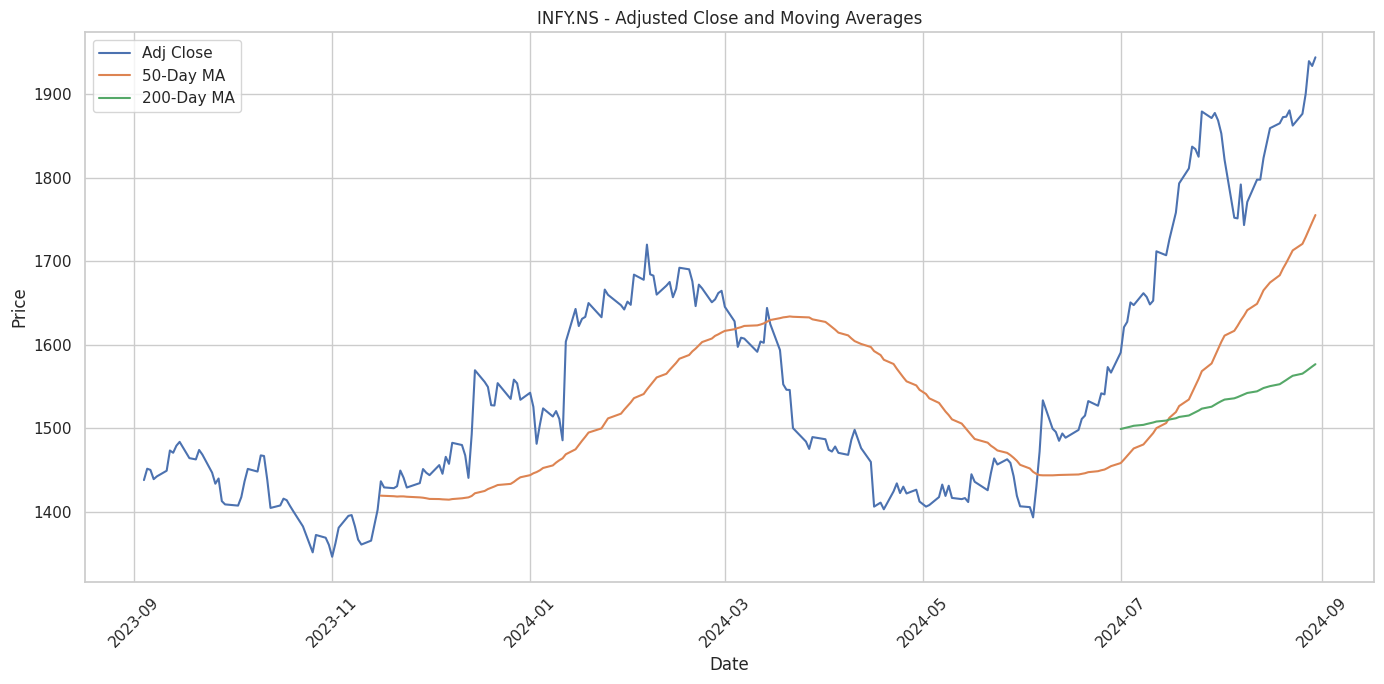

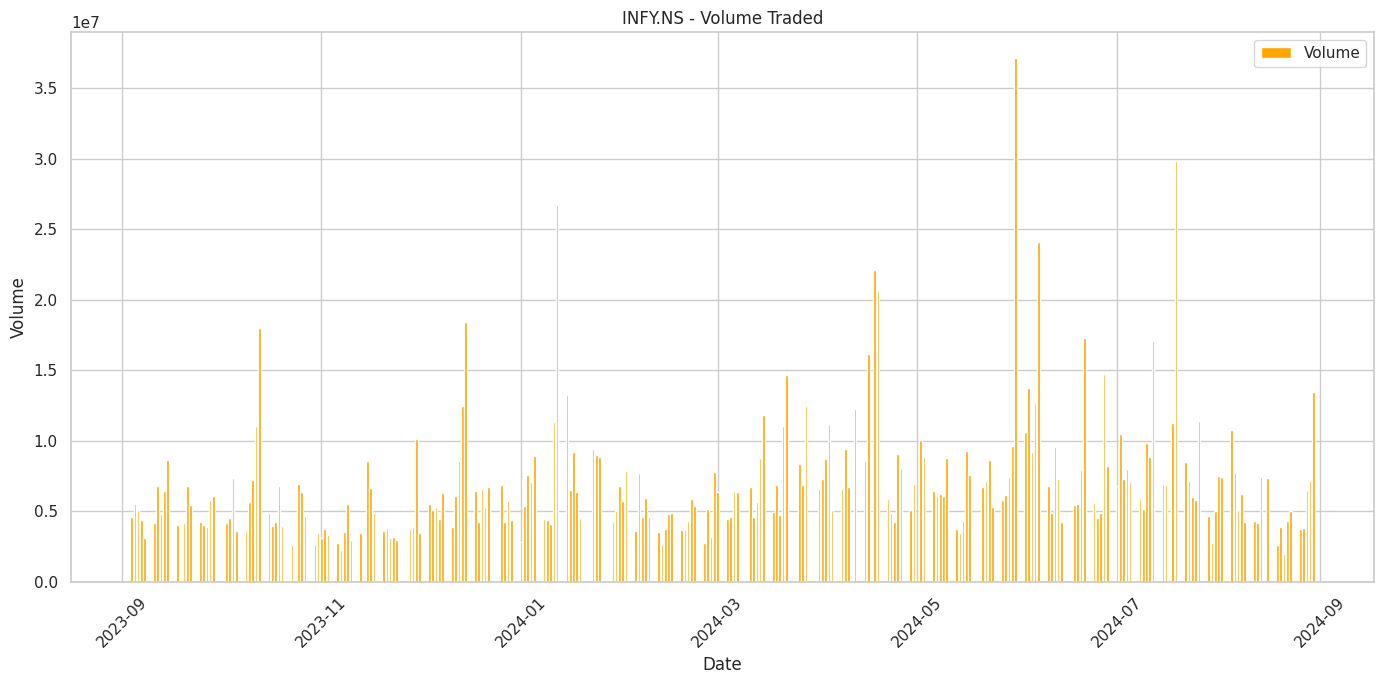

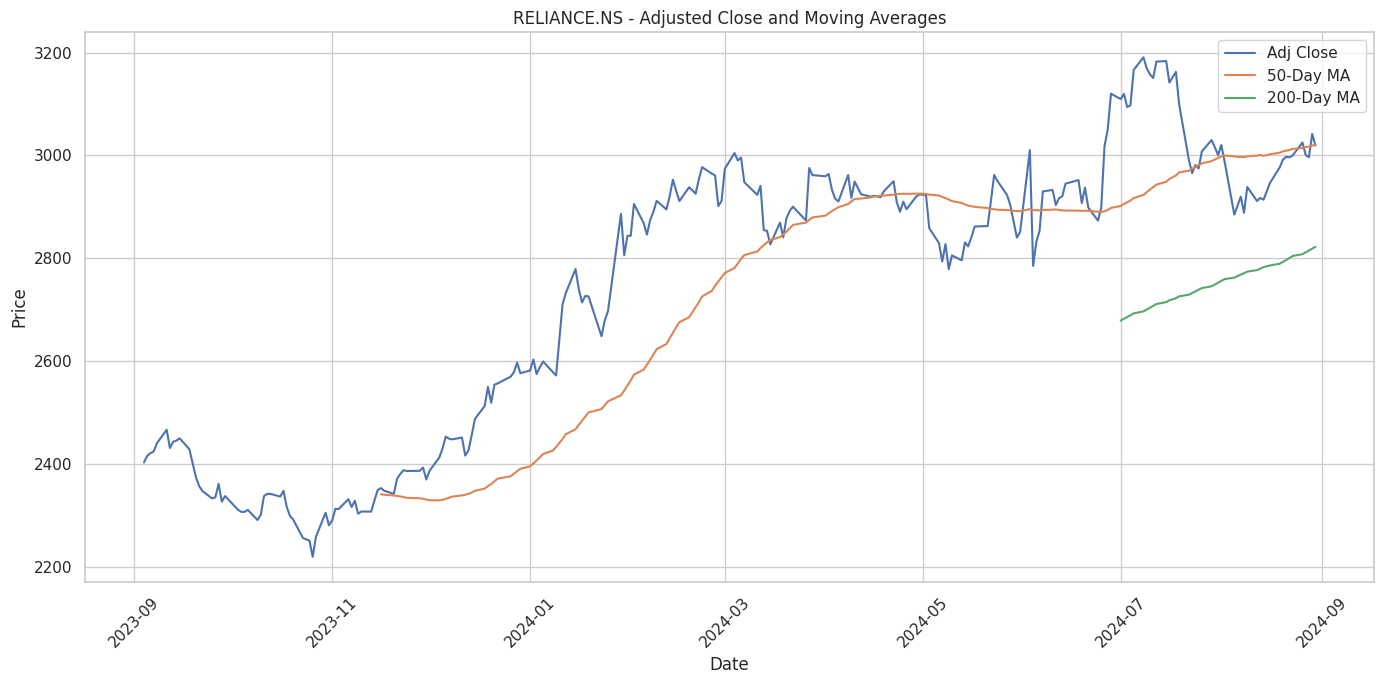

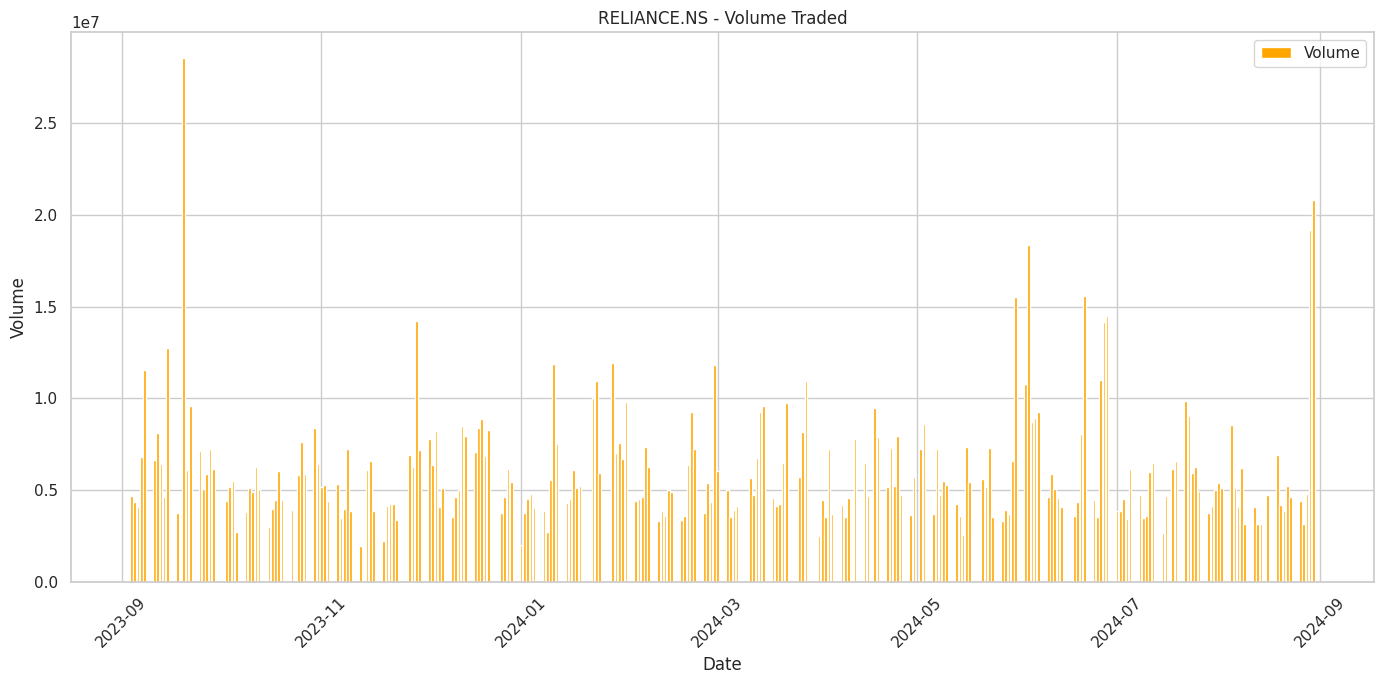

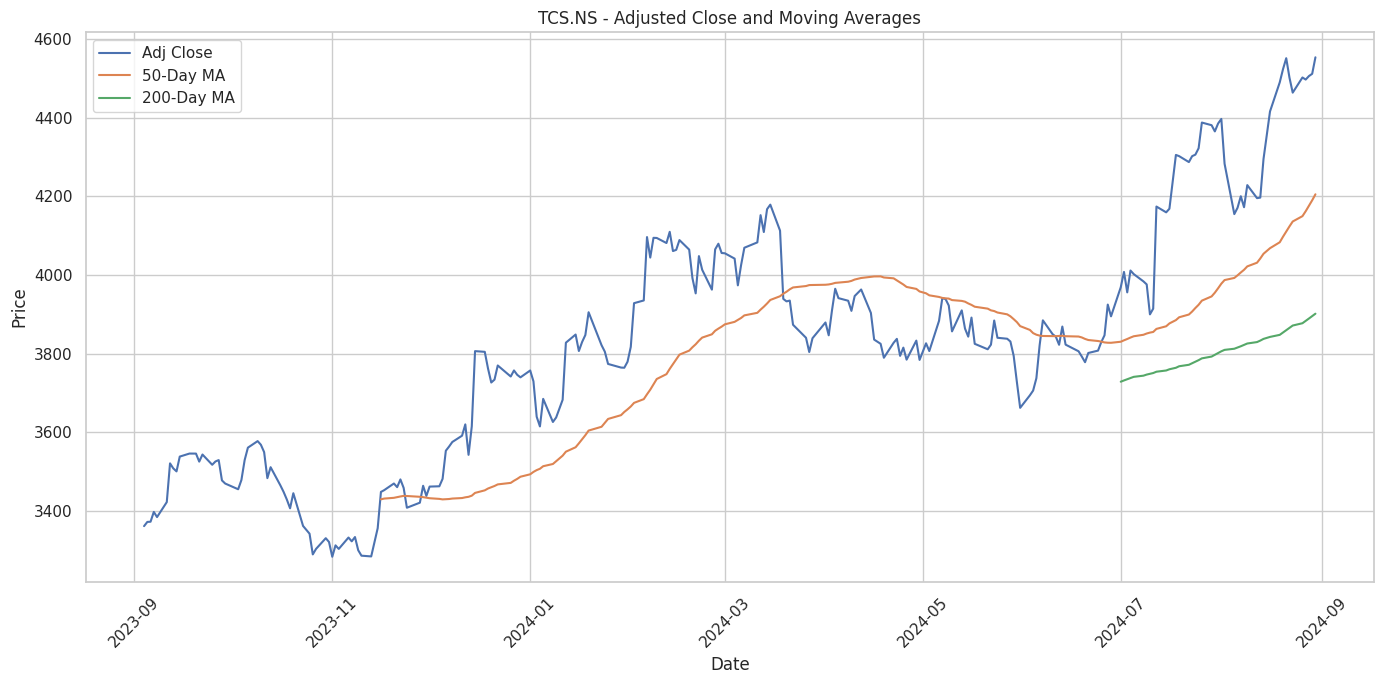

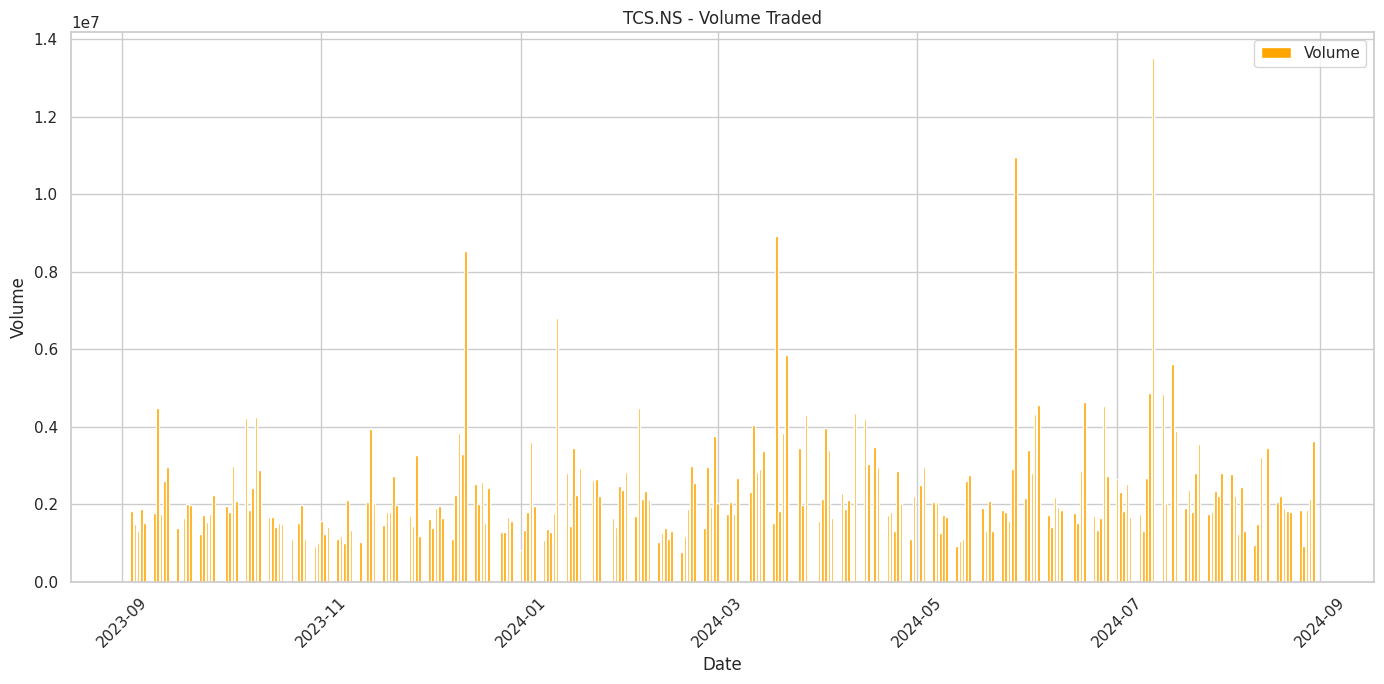

In [30]:
short_window = 50
long_window = 200

stock_data.set_index('Date', inplace=True)
unique_tickers = stock_data['Ticker'].unique()

for ticker in unique_tickers:
    ticker_data = stock_data[stock_data['Ticker'] == ticker].copy()
    ticker_data['50_MA'] = ticker_data['Adj Close'].rolling(window=short_window).mean()
    ticker_data['200_MA'] = ticker_data['Adj Close'].rolling(window=long_window).mean()

    plt.figure(figsize=(14, 7))
    plt.plot(ticker_data.index, ticker_data['Adj Close'], label='Adj Close')
    plt.plot(ticker_data.index, ticker_data['50_MA'], label='50-Day MA')
    plt.plot(ticker_data.index, ticker_data['200_MA'], label='200-Day MA')
    plt.title(f'{ticker} - Adjusted Close and Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 7))
    plt.bar(ticker_data.index, ticker_data['Volume'], label='Volume', color='orange')
    plt.title(f'{ticker} - Volume Traded')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

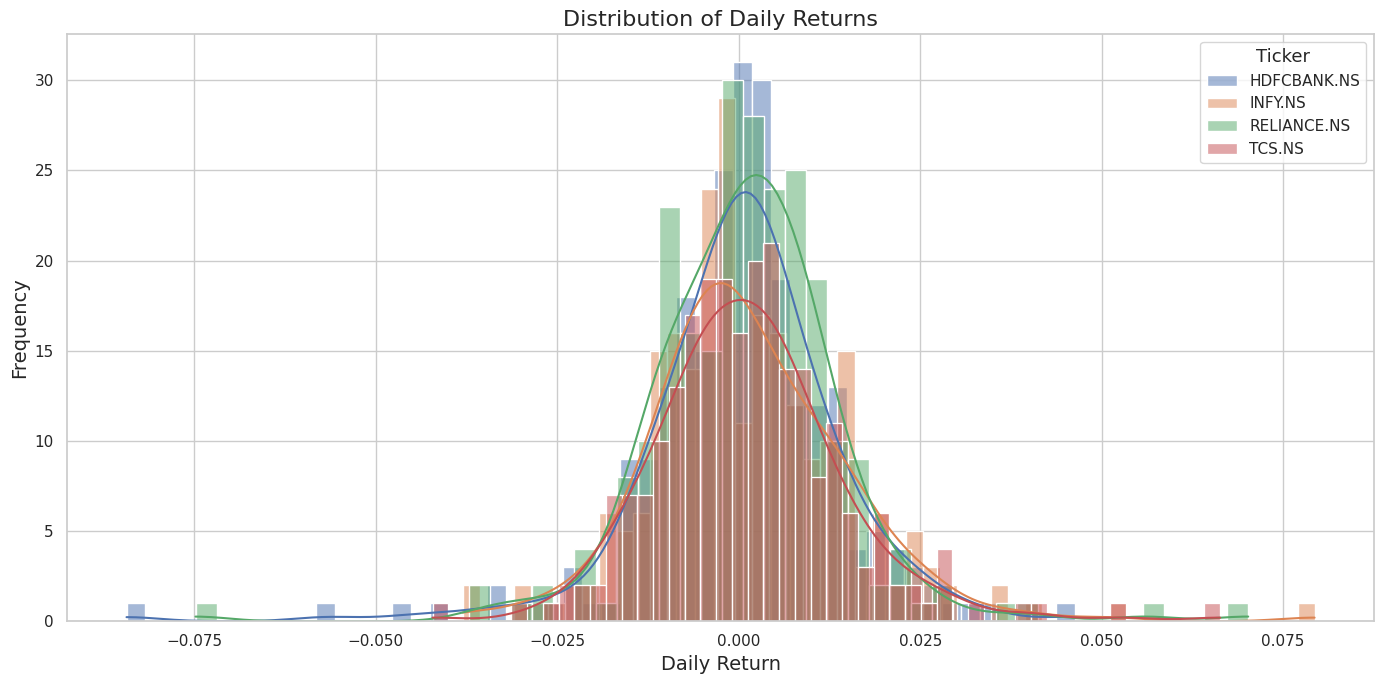

In [31]:
stock_data['Daily Return'] = stock_data.groupby('Ticker')['Adj Close'].pct_change()

plt.figure(figsize=(14, 7))
sns.set(style='whitegrid')

for ticker in unique_tickers:
    ticker_data = stock_data[stock_data['Ticker'] == ticker]
    sns.histplot(ticker_data['Daily Return'].dropna(), bins=50, kde=True, label=ticker, alpha=0.5)

plt.title('Distribution of Daily Returns', fontsize=16)
plt.xlabel('Daily Return', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Ticker', title_fontsize='13', fontsize='11')
plt.grid(True)
plt.tight_layout()
plt.show()

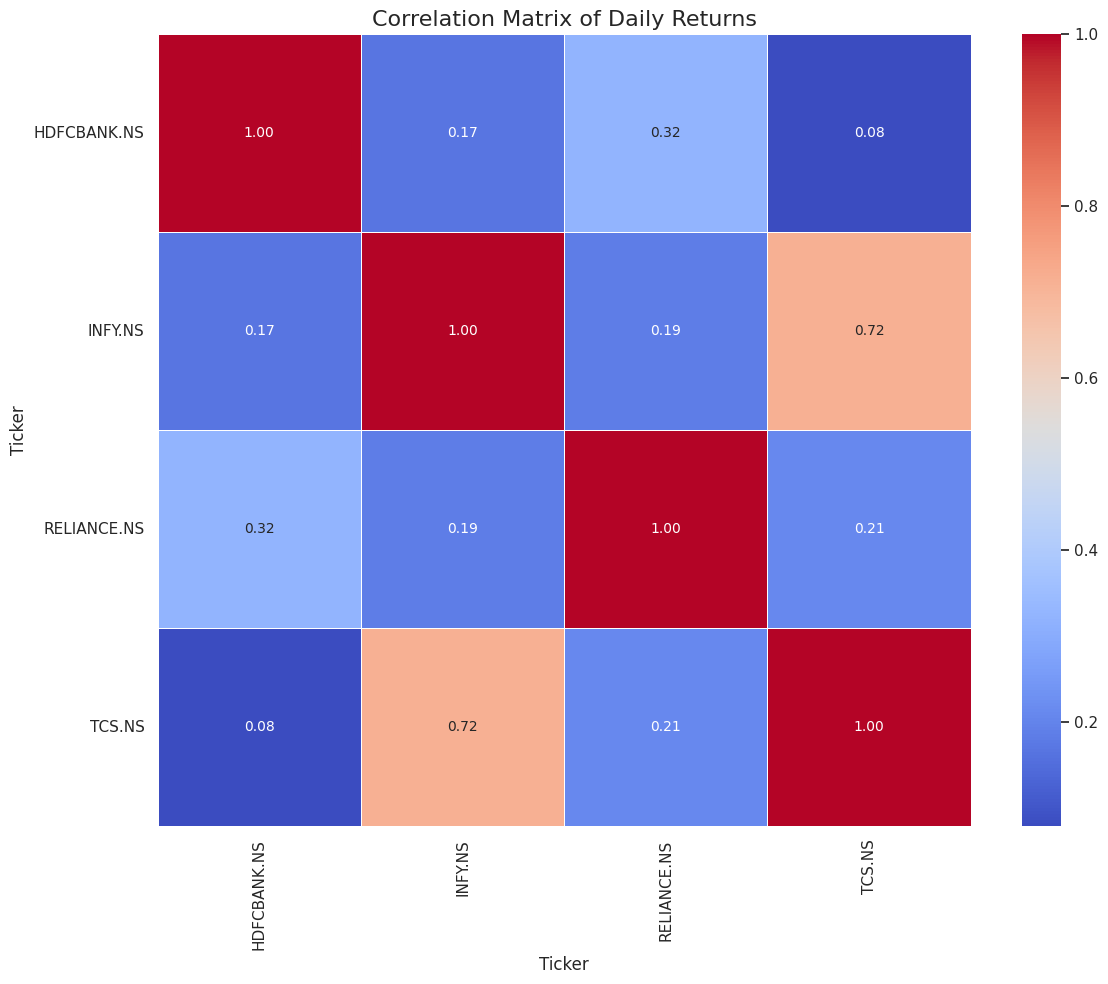

In [32]:
daily_returns = stock_data.pivot_table(index='Date', columns='Ticker', values='Daily Return')
correlation_matrix = daily_returns.corr()

plt.figure(figsize=(12, 10))
sns.set(style='whitegrid')

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, fmt='.2f', annot_kws={"size": 10})
plt.title('Correlation Matrix of Daily Returns', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [33]:
import numpy as np

expected_returns = daily_returns.mean() * 252
volatility = daily_returns.std() * np.sqrt(252)

stock_stats = pd.DataFrame({
    'Expected Return': expected_returns,
    'Volatility': volatility
})

stock_stats

,Expected Return,Volatility
Ticker,,
HDFCBANK.NS,0.072028,0.217531
INFY.NS,0.339353,0.221792
RELIANCE.NS,0.261677,0.213366
TCS.NS,0.338872,0.207670


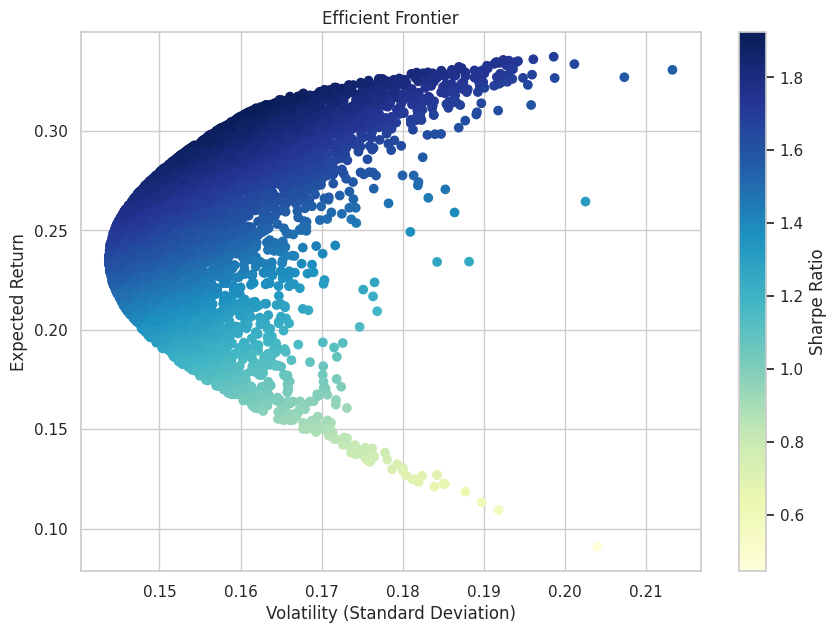

In [34]:


def portfolio_performance(weights, returns, cov_matrix):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility


num_portfolios = 10000


results = np.zeros((3, num_portfolios))

cov_matrix = daily_returns.cov() * 252

np.random.seed(42)

for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)

    results[0,i] = portfolio_return
    results[1,i] = portfolio_volatility
    results[2,i] = portfolio_return / portfolio_volatility  # Sharpe Ratio

plt.figure(figsize=(10, 7))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='YlGnBu', marker='o')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)
plt.show()

### Identifying the portfolio with the maximum Sharpe ratio

In [35]:
max_sharpe_idx = np.argmax(results[2])
max_sharpe_return = results[0, max_sharpe_idx]
max_sharpe_volatility = results[1, max_sharpe_idx]
max_sharpe_ratio = results[2, max_sharpe_idx]

max_sharpe_return, max_sharpe_volatility, max_sharpe_ratio

(0.31151104511688654, 0.1619119650722844, 1.9239532111034212)

The portfolio with the maximum Sharpe ratio has the following characteristics:

Expected Return: ~26.08%
Volatility: ~15.54%
Sharpe Ratio: ~1.68

### Identifying the weights of the stocks in the portfolio that yield the maximum Sharpe ratio

In [36]:
max_sharpe_weights = np.zeros(len(unique_tickers))

for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)

    if results[2, i] == max_sharpe_ratio:
        max_sharpe_weights = weights
        break

portfolio_weights_df = pd.DataFrame({
    'Ticker': unique_tickers,
    'Weight': max_sharpe_weights
})

portfolio_weights_df

,Ticker,Weight
0,HDFCBANK.NS,0.104791
1,INFY.NS,0.380944
2,RELIANCE.NS,0.480381
3,TCS.NS,0.033884
